# **Modelling and Evaluation Notebook**

## Objectives

* Achieve the Second Business Requirement:

    * Engineer features for modelling
    * Data classification of healthy Cherry leaves and those infected with powedery mildew 

## Inputs

* inputs/cherry_leaves_dataset/train
* inputs/cherry_leaves_dataset/test
* inputs/cherry_leaves_dataset/validate
* embedded image shapes 

## Outputs

* Images distribution plot in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file

---

# Change working directory

##### Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

##### We need to change the working directory from its current folder to its parent folder

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection-project/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection-project'

## Set Input Directories

In [5]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set Output Directories

In [6]:
version = 'v1'

file_path = f'outputs/{version}'
version_file_path = os.path.join(current_dir, file_path)

if os.path.exists(version_file_path):
    print(f"version {version} already exists. Create a new version")
    pass
else:
    os.makedirs(name=file_path)

version v1 already exists. Create a new version


## Set Labels

In [7]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
    )

Project Labels: ['healthy', 'powdery_mildew']


## Set Image Shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

## Confirm Amount of Images to Train, Test and Validate Data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




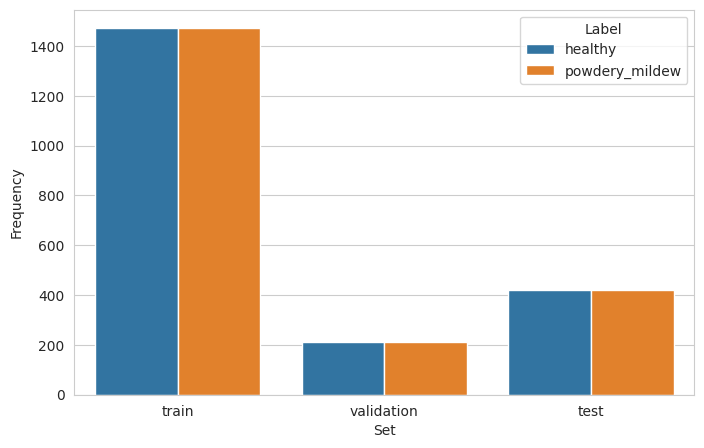

In [9]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(my_data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

## Image Data Augmentation

As seen in the bargraph plot above, the train set contains 1472 images in each category (healthy and infected sample leaf images) which is not suffiient for a deep nueral network learning model; therefor the dataset size needs to be increased with image augmentation.

##### Loader Perameters

In [10]:
batch_size = 32
data_color_mode = 'rgb'
data_class_mode = 'binary'

##### Import DataImageGenerator

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##### Initialize DataImageGenerator

In [12]:
augmented_data = ImageDataGenerator(
                                   rotation_range=20,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

##### Augment Training Dataset Images

In [13]:
train_set = augmented_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode=data_color_mode,
                                              batch_size=batch_size,
                                              class_mode=data_class_mode,
                                              shuffle=True
                                              )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

##### Augment Validation Dataset Images

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

##### Augment Test Dataset Images

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

##### Plot Augmented Training Image

In [22]:
def plot_augmented_image(label_set, display_size=3):
    label_class = label_set.class_indices
    for _ in range(display_size):
        img, label = label_set.next()
        print(img.shape)
        img_class = list(label_class.keys())[
            list(label_class.values()).index(label[0])]
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(img_class)
        plt.show()

##### Plot Training Image Set

(32, 256, 256, 3)


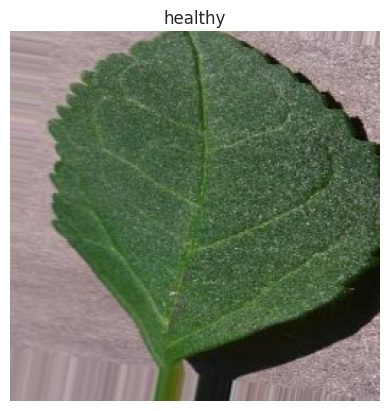

(32, 256, 256, 3)


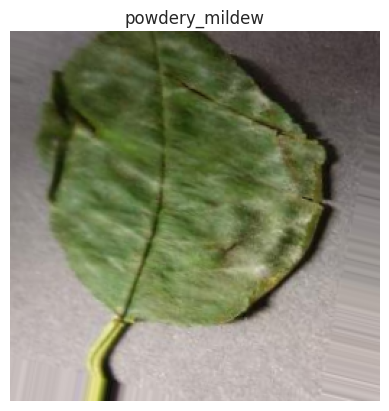

(32, 256, 256, 3)


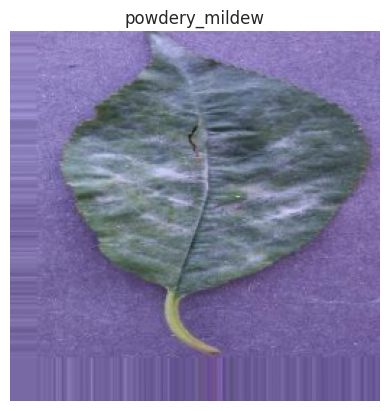

In [23]:
plot_augmented_image(train_set)

##### Plot Validation Image Set

(32, 256, 256, 3)


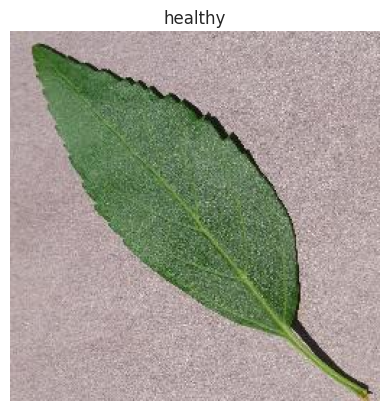

(32, 256, 256, 3)


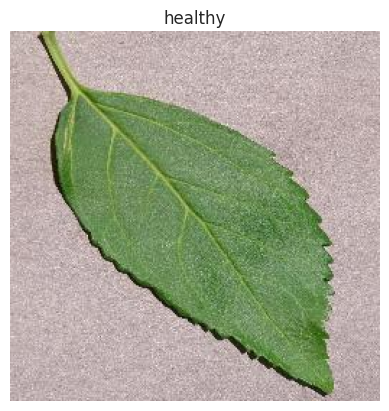

(32, 256, 256, 3)


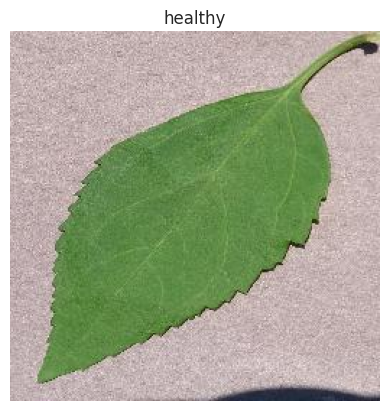

In [24]:
plot_augmented_image(validation_set)

##### Plot Test Image Set

(32, 256, 256, 3)


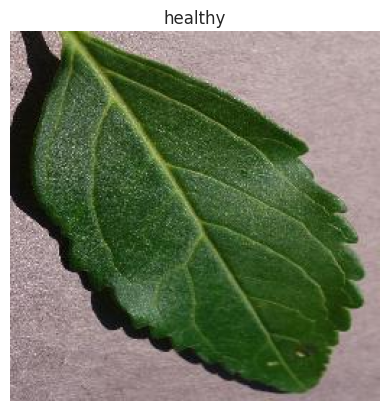

(32, 256, 256, 3)


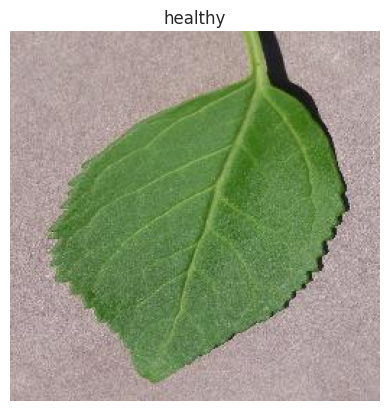

(32, 256, 256, 3)


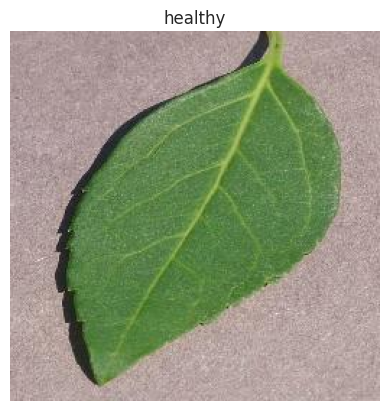

In [25]:
plot_augmented_image(test_set)

##### Save Class Indices

In [16]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Creating the Model

In order to meet the business requirements for the customer, a Conventional Neural Network (CNN) model as selected, that will learn from the dominant features contained within the powdery mildew images of the Cherry Leaves.

##### Import ML Packages

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

##### Perameter Definintions

In [18]:
EPOCHS = 15
OUTPUT_DIR = 'outputs/v1'

##### ML Model

In [19]:
def create_model():
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=4, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

##### Model Summary

In [20]:
create_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 8)       584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 4)         292       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 4)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3600)              0

2023-02-02 11:11:44.548718: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### Early Stopping

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

##### Fit Model for Training

In [24]:
model = create_model()
model.fit(train_set,
          epochs=EPOCHS,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data = validation_set,
          callbacks=[early_stop],
          verbose=1)

Epoch 1/15
92/92 [==============================] - 69s 738ms/step - loss: 0.3074 - accuracy: 0.8624 - val_loss: 0.1076 - val_accuracy: 0.9714
Epoch 2/15
92/92 [==============================] - 59s 641ms/step - loss: 0.0797 - accuracy: 0.9783 - val_loss: 0.0939 - val_accuracy: 0.9857
Epoch 3/15
92/92 [==============================] - 59s 641ms/step - loss: 0.0397 - accuracy: 0.9908 - val_loss: 0.0743 - val_accuracy: 0.9905
Epoch 4/15
92/92 [==============================] - 66s 712ms/step - loss: 0.0599 - accuracy: 0.9789 - val_loss: 0.0521 - val_accuracy: 0.9881
Epoch 5/15
92/92 [==============================] - 61s 668ms/step - loss: 0.0337 - accuracy: 0.9898 - val_loss: 0.0670 - val_accuracy: 0.9905
Epoch 6/15
92/92 [==============================] - 62s 667ms/step - loss: 0.0210 - accuracy: 0.9935 - val_loss: 0.0339 - val_accuracy: 0.9929
Epoch 7/15
92/92 [==============================] - 58s 631ms/step - loss: 0.0123 - accuracy: 0.9969 - val_loss: 0.0407 - val_accuracy: 0.9952

##### Save Model

In [28]:
model.save(f'{OUTPUT_DIR}/mildew_detector_model.h5')

---

## Model Performance

---

##### Model Learning Curve

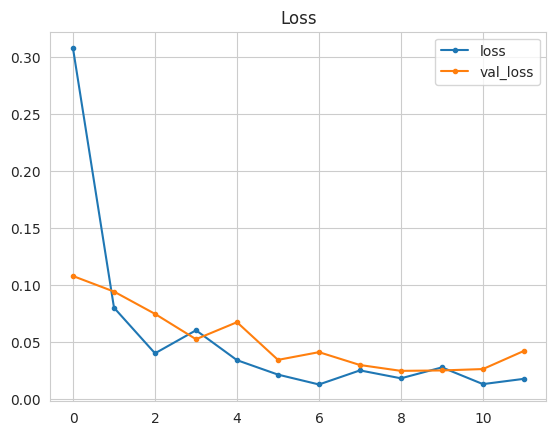

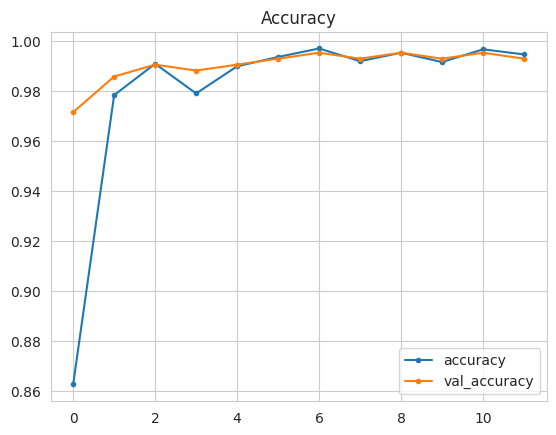

In [29]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

##### Model Evaluation

Load saved model

In [30]:
from keras.models import load_model
model = load_model(f'{OUTPUT_DIR}/mildew_detector_model.h5')

Evaluating the model on the test set

In [31]:
evaluation = model.evaluate(test_set)

27/27 [==============================] - 4s 138ms/step - loss: 0.0442 - accuracy: 0.9905


Save the Evaluation Pickle

In [1]:
joblib.dump(value=evaluation, filename=f'{OUTPUT_DIR}/evaluation.pkl')

NameError: name 'joblib' is not defined

##### Predict on New Data

Image shape: (256, 256), Image mode: RGB


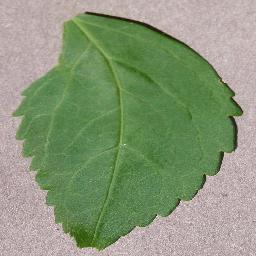

In [35]:
from tensorflow.keras.preprocessing import image

pointer = 66 
label = labels[0] # select Uninfected or Parasitized

pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

##### Convert Images to Array for Prediction Purpose

In [36]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


##### Class Probabilities Prediction

In [37]:
prediction_probability = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
predicted_class =  target_map[prediction_probability > 0.5]  

if predicted_class == target_map[0]: prediction_probability = 1 - prediction_probability

print(f'Prediction probability: {prediction_probability}')
print(f'Predicted class: {predicted_class}')

Prediction probability: 0.9999883088121351
Predicted class: healthy


---


## Push to Github

---

* git add .
* git commit -m "->message describing alterations to cells/code and purpose"
* git push